<a href="https://colab.research.google.com/github/killerdds01/Pitone-IA/blob/main/progettoProgettoso.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Cella 1: Importazioni e Configurazione Iniziale

# Importazioni PyTorch
import torch
import torch.nn as nn # building block per le reti neurali
import torch.optim as optim # algoritmi di ottimizzazione
import torchvision # libreria per computer vision
import torchvision.transforms as transforms # trasformazioni per immagini
import torchvision.datasets as datasets # per caricare dataset comuni come ImageFolder
from torch.optim import lr_scheduler
from torchvision import transforms

from torch.utils.data import DataLoader, random_split # per iterare sul dataset e dividerlo

# Importazioni per metriche e visualizzazioni
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import numpy as np # per manipolare array numerici
import matplotlib.pyplot as plt # per creare grafici e visualizzazioni
import seaborn as sns # per grafici statistici più belli

# Importazioni per utilità
import time # per misurare il tempo di esecuzione
import os # per operazioni sul file system (es. percorsi file)
import copy

print(f"Pytorch Version: {torch.__version__}") # stampa la versione di PyTorch
print(f"CUDA Available: {torch.cuda.is_available()}") # verifica se è disponibile una GPU (CUDA)
if torch.cuda.is_available(): # se CUDA è disponibile
    print(f"CUDA Version: {torch.version.cuda}") # stampa la versione di CUDA
    print(f"GPU Name: {torch.cuda.get_device_name(0)}") # stampa il nome della prima GPU disponibile

# imposta il dispositivo da utilizzare (GPU se disponibile, altrimenti CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}") # stampa il dispositivo in utilizzo

Pytorch Version: 2.6.0+cu124
CUDA Available: False
Using device: cpu


In [ ]:
# Cella 1: Carica kaggle.json
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"davidedisanto","key":"09b687d14d916a45a495a3da24a792c8"}'}

In [ ]:
!ls -l

total 87508
-rw-r--r-- 1 root root 44801688 Jul 25 18:21 best_model_finetuned_final.pth
-rw-r--r-- 1 root root 44801940 Jul 25 17:54 best_model_transfer_learning.pth
drwxr-xr-x 1 root root     4096 Jul 24 13:37 sample_data


In [2]:
# Cella 2: Configura Kaggle API
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

mv: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [3]:
# Cella 3: Scarica il NUOVO Dataset (Multi class garbage classification Dataset)
import kagglehub

dataset_identifier = "vishallazrus/multi-class-garbage-classification-dataset"
path = kagglehub.dataset_download(dataset_identifier)

print("Path to new dataset files:", path)

Path to new dataset files: /kaggle/input/multi-class-garbage-classification-dataset


In [4]:
# Cella 4: Decomprimi il Nuovo Dataset
zip_file_name = "multi-class-garbage-classification-dataset.zip"
extraction_path = "./garbage_dataset_with_organic"
!unzip -q {zip_file_name} -d {extraction_path}

print(f"Dataset decompresso in: {extraction_path}")

unzip:  cannot find or open multi-class-garbage-classification-dataset.zip, multi-class-garbage-classification-dataset.zip.zip or multi-class-garbage-classification-dataset.zip.ZIP.
Dataset decompresso in: ./garbage_dataset_with_organic


In [ ]:
# Cella per esplorare la sottocartella annidata
import os

nested_path = "/kaggle/input/multi-class-garbage-classification-dataset/Multi class garbage classification"
print(f"Contenuto di '{nested_path}':")
print(os.listdir(nested_path))

# Alternativa con !ls -l (mostra più dettagli)
# !ls -l "/kaggle/input/multi-class-garbage-classification-dataset/Multi class garbage classification"

Contenuto di '/kaggle/input/multi-class-garbage-classification-dataset/Multi class garbage classification':


FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/input/multi-class-garbage-classification-dataset/Multi class garbage classification'

In [ ]:
# Cella 3: Definizione della CNN Personalizzata (con Batch Normalization)

print("\n<<< Definizione CNN >>>")

class CustomCNN(nn.Module):
    # costruttore della classe, definisce gli strati della rete
    def __init__(self, num_classes=7): # num_classes impostato a 7 per il nostro dataset di rifiuti
        super(CustomCNN, self).__init__() # chiamata al costruttore della classe base nn.Module

        # blocco convoluzionale 1
        # Input: 3 canali (RGB), Output: 32 filtri
        # Immagine 224x224x3 -> Conv2d (3x3 kernel, padding=1) -> 224x224x32 -> MaxPool2d (2x2 kernel) -> 112x112x32
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1) # primo strato convoluzionale
        self.bn1 = nn.BatchNorm2d(32) # Nuova riga: Batch Normalization per 32 canali in output
        self.relu1 = nn.ReLU() # funzione di attivazione ReLU
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) # strato di Max Pooling
        self.dropout1 = nn.Dropout(p=0.25) # dropout per regolarizzazione dopo il pooling

        # blocco convoluzionale 2
        # Input: 32 canali, Output: 64 filtri
        # Immagine 112x112x32 -> Conv2d (3x3 kernel, padding=1) -> 112x112x64 -> MaxPool2d (2x2 kernel) -> 56x56x64
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64) # Nuova riga: Batch Normalization per 64 canali in output
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout2 = nn.Dropout(p=0.25)

        # blocco convoluzionale 3
        # Input: 64 canali, Output: 128 filtri
        # Immagine 56x56x64 -> Conv2d (3x3 kernel, padding=1) -> 56x56x128 -> MaxPool2d (2x2 kernel) -> 28x28x128
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128) # Nuova riga: Batch Normalization per 128 canali in output
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout3 = nn.Dropout(p=0.25)

        # Strati Fully Connected (FC)
        # L'output in arrivo dal blocco convoluzionale è 28x28x128
        # Appiattire il volume in un singolo vettore prima di passarlo allo strato lineare: 28 * 28 * 128 = 100352
        self.fc1 = nn.Linear(in_features=100352, out_features=512) # primo strato lineare
        self.bn_fc1 = nn.BatchNorm1d(512) # Nuova riga: Batch Normalization per lo strato FC
        self.relu_fc1 = nn.ReLU()
        self.dropout_fc = nn.Dropout(p=0.5) # dropout più elevato per i layer FC

        # Strato di Output
        # Input: 512, Output: num_classes (7 per il nostro dataset)
        self.fc2 = nn.Linear(in_features=512, out_features=num_classes) # strato lineare finale

    # definisce come i dati fluiscono attraverso la rete (passaggio in avanti)
    def forward(self, x):
        # blocco convoluzionale 1
        x = self.conv1(x)
        x = self.bn1(x) # Nuova riga: applica BatchNorm1 dopo conv1
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.dropout1(x)

        # blocco convoluzionale 2
        x = self.conv2(x)
        x = self.bn2(x) # Nuova riga: applica BatchNorm2 dopo conv2
        x = self.relu2(x)
        x = self.pool2(x)
        x = self.dropout2(x)

        # blocco convoluzionale 3
        x = self.conv3(x)
        x = self.bn3(x) # Nuova riga: applica BatchNorm3 dopo conv3
        x = self.relu3(x)
        x = self.pool3(x)
        x = self.dropout3(x)

        # appiattisce l'output dei layer convoluzionali per passarlo ai layer lineari
        # x.size(0) è la dimensione del batch
        # -1 dice a PyTorch di calcolare la dimensione rimanente automaticamente
        x = x.view(x.size(0), -1)

        # applicazione degli strati FC
        x = self.fc1(x)
        x = self.bn_fc1(x) # Nuova riga: applica BatchNorm al layer FC
        x = self.relu_fc1(x)
        x = self.dropout_fc(x)

        x = self.fc2(x) # output finale
        # per la classificazione multiclasse non applichiamo softmax qui,
        # perché CrossEntropyLoss di PyTorch include già la softmax al suo interno
        return x

# istanzia il modello e spostalo sul dispositivo (GPU o CPU)
model_scratch = CustomCNN(num_classes=num_classes).to(device)

# stampa un riepilogo del modello per vedere i layer e il numero di parametri
print(model_scratch)

# riepilogo più dettagliato dei parametri addestrabili
total_params = sum(p.numel() for p in model_scratch.parameters() if p.requires_grad)
print(f"Parametri addestrabili della CNN from scratch (con BatchNorm): {total_params:,}")


<<< Definizione CNN >>>
CustomCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.25, inplace=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout2): Dropout(p=0.25, inplace=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU()
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout3): Dropout(p=0.25, inplace=False)
  (fc1): Linear(in


<<< Caricamento e Preparazione Dataset Rifiuti >>>
Dimensioni del set di addestramento: 1676 immagini
Dimensioni del set di validazione: 420 immagini
Dimensioni del set di test: 245 immagini
Numero di batch per l'addestramento: 27
Numero di batch per la validazione: 7
Numero di batch per il test: 4

Convalida conteggio immagini per le NUOVE classi (Train/Val/Test):
Distribuzione classi Training (rimappate):
  plastica: 351 immagini
  carta: 731 immagini
  vetro: 366 immagini
  organico: 112 immagini
  indifferenziato: 116 immagini
Distribuzione classi Validazione (rimappate):
  plastica: 87 immagini
  carta: 186 immagini
  vetro: 95 immagini
  organico: 27 immagini
  indifferenziato: 25 immagini
Distribuzione classi Test (rimappate):
  plastica: 44 immagini
  carta: 80 immagini
  vetro: 40 immagini
  organico: 38 immagini
  indifferenziato: 43 immagini


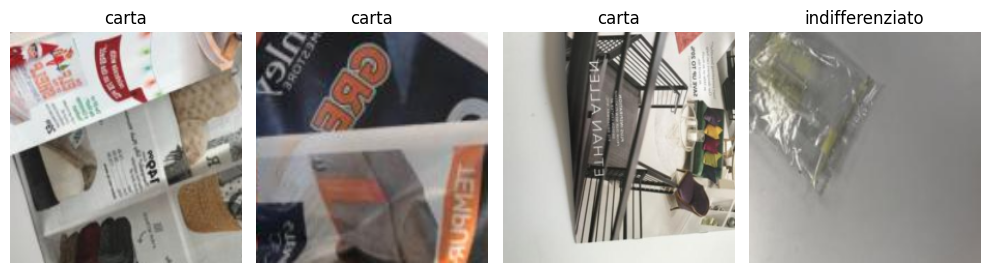

Forma dell'input per il modello (Canali, Altezza, Larghezza): (3, 224, 224)
Numero totale di classi per il modello (DOPO raggruppamenti/esclusioni): 5

Dataset caricato e pronto per l'addestramento del modello!


In [5]:
# Cella 2: Caricamento e Preparazione del Dataset Rifiuti con PyTorch

print("\n<<< Caricamento e Preparazione Dataset Rifiuti >>>")

import collections # Manteniamo questo per i controlli di sanità

# definizione del percorso base del dataset
DATA_PATH = '/kaggle/input/multi-class-garbage-classification-dataset/Multi class garbage classification'

# Mappatura delle classi originali del dataset alle 5 classi del progetto
class_mapping_original_to_final = {
    'plastic': 0,      # Nuova classe 0: Plastica
    'paper': 1,        # Nuova classe 1: Carta
    'cardboard': 1,    # Mappa cardboard a Carta
    'glass': 2,        # Nuova classe 2: Vetro
    'compost': 3,      # Nuova classe 3: Organico
    'trash': 4         # Nuova classe 4: Indifferenziato
    # 'metal' NON è inclusa, verrà filtrata
}

# Definisci i nomi delle classi finali (per la visualizzazione e num_classes)
final_class_names = ['plastica', 'carta', 'vetro', 'organico', 'indifferenziato']
num_classes = len(final_class_names) # num_classes sarà 5

# Trasformazioni delle immagini (preprocessing e data augmentation)
# ***** ALTAMENTE SEMPLIFICATE *****
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224), # Solo la base, senza scale aggressive
        transforms.RandomHorizontalFlip(), # Base augmentation
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Caricamento dei dataset RAW usando ImageFolder (senza trasformazioni iniziali)
train_dataset_original = datasets.ImageFolder(os.path.join(DATA_PATH, 'train'))
test_dataset_original = datasets.ImageFolder(os.path.join(DATA_PATH, 'test'))

# Funzione per filtrare e rimappare i campioni
def get_remapped_samples(original_dataset, class_mapping):
    remapped_samples = []
    for path, original_class_idx in original_dataset.samples:
        original_class_name = original_dataset.classes[original_class_idx]
        if original_class_name in class_mapping:
            remapped_samples.append((path, class_mapping[original_class_name]))
    return remapped_samples

# Ottieni i campioni filtrati e rimappati
train_remapped_samples = get_remapped_samples(train_dataset_original, class_mapping_original_to_final)
test_remapped_samples = get_remapped_samples(test_dataset_original, class_mapping_original_to_final)

# Creiamo un Custom Dataset che userà i campioni filtrati/rimappati e le nostre trasformazioni
class CustomRemappedDataset(torch.utils.data.Dataset):
    def __init__(self, samples, transform=None):
        self.samples = samples
        self.transform = transform
        self.classes = final_class_names # Diamo i nomi delle classi finali
        self.class_to_idx = {name: i for i, name in enumerate(final_class_names)}

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, label = self.samples[idx]
        image = datasets.folder.default_loader(path) # Carica l'immagine (PIL Image)
        if self.transform:
            image = self.transform(image) # Applica le trasformazioni
        return image, label

# Inizializza i nuovi dataset con i campioni filtrati e le trasformazioni corrette
train_dataset_full = CustomRemappedDataset(train_remapped_samples, transform=data_transforms['train'])
test_dataset = CustomRemappedDataset(test_remapped_samples, transform=data_transforms['test'])

# Suddivisione del dataset in 80% train, 20% validation (dal set di training completo)
train_size = int(0.8 * len(train_dataset_full))
val_size = len(train_dataset_full) - train_size
train_dataset, val_dataset = random_split(train_dataset_full, [train_size, val_size])

# Creazione dei DataLoader
BATCH_SIZE = 64
num_workers = 2

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=num_workers)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=num_workers)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=num_workers)

print(f"Dimensioni del set di addestramento: {len(train_dataset)} immagini")
print(f"Dimensioni del set di validazione: {len(val_dataset)} immagini")
print(f"Dimensioni del set di test: {len(test_dataset)} immagini")
print(f"Numero di batch per l'addestramento: {len(train_loader)}")
print(f"Numero di batch per la validazione: {len(val_loader)}")
print(f"Numero di batch per il test: {len(test_loader)}")

# NUOVO CONTROLLO DI SANITA': CONTA LE IMMAGINI PER CLASSE
print("\nConvalida conteggio immagini per le NUOVE classi (Train/Val/Test):")
train_class_counts = collections.Counter([train_dataset_full.samples[idx][1] for idx in train_dataset.indices])
val_class_counts = collections.Counter([train_dataset_full.samples[idx][1] for idx in val_dataset.indices])
test_class_counts = collections.Counter([s[1] for s in test_dataset.samples])

print("Distribuzione classi Training (rimappate):")
for class_idx in sorted(train_class_counts.keys()):
    print(f"  {final_class_names[class_idx]}: {train_class_counts[class_idx]} immagini")

print("Distribuzione classi Validazione (rimappate):")
for class_idx in sorted(val_class_counts.keys()):
    print(f"  {final_class_names[class_idx]}: {val_class_counts[class_idx]} immagini")

print("Distribuzione classi Test (rimappate):")
for class_idx in sorted(test_class_counts.keys()):
    print(f"  {final_class_names[class_idx]}: {test_class_counts[class_idx]} immagini")


# visualizzazione e metriche
class_names = final_class_names

def imshow(img):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    img = img * std + mean
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(train_loader)
images, labels = next(dataiter)

plt.figure(figsize = (10, 5))
for i in range(4):
    plt.subplot(1, 4, i + 1)
    img = images[i]
    mean_val = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std_val = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    img_denormalized = img * std_val + mean_val
    npimg = img_denormalized.numpy()

    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(class_names[labels[i].item()])
    plt.axis('off')
plt.tight_layout()
plt.show()

input_shape = (3, 224, 224)
num_classes = len(final_class_names)

print(f"Forma dell'input per il modello (Canali, Altezza, Larghezza): {input_shape}")
print(f"Numero totale di classi per il modello (DOPO raggruppamenti/esclusioni): {num_classes}")
print("\nDataset caricato e pronto per l'addestramento del modello!")

In [6]:
# Cella 3: Architettura del Modello e Funzione di Addestramento

print("\n<<< Definizione Architettura del Modello >>>")

# Caricamento del modello pre-addestrato (ResNet18)
model_transfer = torchvision.models.resnet18(weights=torchvision.models.ResNet18_Weights.IMAGENET1K_V1)

# Sostituzione del layer finale completamente connesso (Fully Connected layer)
num_ftrs = model_transfer.fc.in_features
model_transfer.fc = nn.Linear(num_ftrs, num_classes)

# --- LOGICA DI CONGELAMENTO ROBUSTA (COME GIA' FATTO E FUNZIONANTE) ---
for param in model_transfer.parameters():
    param.requires_grad = False
for param in model_transfer.fc.parameters():
    param.requires_grad = True
# --- FINE LOGICA DI CONGELAMENTO ROBUSTA ---

model_transfer = model_transfer.to(device)

print("\nModello ResNet18 caricato e modificato:")
print(model_transfer)

print("\nParametri addestrabili (dovrebbe essere solo il layer fc):")
trainable_params_count = 0
for name, param in model_transfer.named_parameters():
    if param.requires_grad:
        print(name)
        trainable_params_count += 1
if trainable_params_count == 0:
    print("ATTENZIONE: Nessun parametro addestrabile trovato! Questo causerà un errore.")
elif trainable_params_count != 2:
    print(f"ATTENZIONE: Trovati {trainable_params_count} parametri addestrabili. Ci si aspettano 2 (fc.weight, fc.bias).")

print("\nModello definito e pronto per l'addestramento!")

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth



<<< Definizione Architettura del Modello >>>


100%|██████████| 44.7M/44.7M [00:00<00:00, 301MB/s]


Modello ResNet18 caricato e modificato:
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=


<<< Avvio Addestramento del Modello (Fase di Fine-tuning Leggero) >>>

<<< Avvio Fine-tuning STANDARD per 60 epoche >>>
Learning Rate iniziale: 1e-03
Parametri addestrabili durante il Fine-tuning Standard (dovrebbe essere solo fc):
fc.weight
fc.bias

<<< Fase 1: Fine-tuning Leggero (Solo layer FC) >>>
Epoch 0/59
----------
train Loss: 1.1807 Acc: 0.5615
val Loss: 0.9652 Acc: 0.6167

Epoch 1/59
----------
train Loss: 0.8585 Acc: 0.7136
val Loss: 0.7531 Acc: 0.7524

Epoch 2/59
----------
train Loss: 0.7346 Acc: 0.7446
val Loss: 0.6653 Acc: 0.7952

Epoch 3/59
----------
train Loss: 0.6619 Acc: 0.7703
val Loss: 0.6477 Acc: 0.7786

Epoch 4/59
----------
train Loss: 0.6070 Acc: 0.7846
val Loss: 0.5761 Acc: 0.7905

Epoch 5/59
----------
train Loss: 0.5856 Acc: 0.7989
val Loss: 0.5728 Acc: 0.8095

Epoch 6/59
----------
train Loss: 0.5420 Acc: 0.8103
val Loss: 0.6038 Acc: 0.7952

Epoch 7/59
----------
train Loss: 0.5347 Acc: 0.8132
val Loss: 0.5691 Acc: 0.8238

Epoch 8/59
----------
train Loss

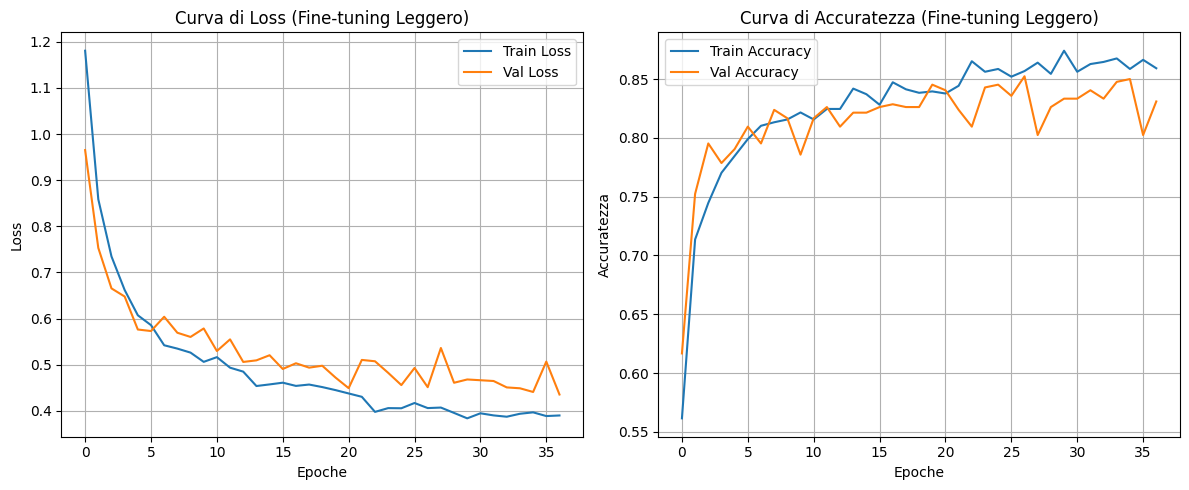


Modello 'best_model_finetuned_light.pth' salvato con successo!

Fase 1 (Fine-tuning Leggero) completato!


In [7]:
print("\n<<< Avvio Addestramento del Modello (Fase di Fine-tuning Leggero) >>>")

num_epochs_finetune = 60 # Numero massimo di epoche per questa fase

# --- Definizione della funzione di perdita (Loss Function) ---
criterion = nn.CrossEntropyLoss()

# --- Definizione dell'ottimizzatore ---
# Aggiorna SOLO i parametri che hanno requires_grad=True (che ora sarà SOLO il layer fc dalla Cella 3)
optimizer_ft = optim.Adam(filter(lambda p: p.requires_grad, model_transfer.parameters()), lr=0.001)

# --- Definizione dello scheduler per il learning rate ---
scheduler_ft = lr_scheduler.ReduceLROnPlateau(optimizer_ft, mode='min', patience=7, factor=0.1, min_lr=1e-08)

print(f"\n<<< Avvio Fine-tuning STANDARD per {num_epochs_finetune} epoche >>>")
print(f"Learning Rate iniziale: {optimizer_ft.param_groups[0]['lr']:.0e}")
print("Parametri addestrabili durante il Fine-tuning Standard (dovrebbe essere solo fc):")
trainable_params_count_check = 0
for name, param in model_transfer.named_parameters():
    if param.requires_grad:
        print(name)
        trainable_params_count_check += 1
if trainable_params_count_check == 0:
    print("ATTENZIONE: L'ottimizzatore non troverà parametri addestrabili. Controlla la Cella 3!")
elif trainable_params_count_check != 2: # fc.weight and fc.bias
    print(f"ATTENZIONE: Trovati {trainable_params_count_check} parametri addestrabili. Ci si aspettano 2 (fc.weight, fc.bias).")


# --- Funzione di addestramento e valutazione (CON Early Stopping) ---
def train_model(model, criterion, optimizer, scheduler, num_epochs=25, patience=10, phase_name="Fine-tuning"):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    epochs_no_improve = 0

    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
                dataloader = train_loader
            else:
                model.eval()
                dataloader = val_loader

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.double() / len(dataloader.dataset)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'val':
                scheduler.step(epoch_loss)
                val_losses.append(epoch_loss)
                val_accuracies.append(epoch_acc.item())

                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())
                    epochs_no_improve = 0
                else:
                    epochs_no_improve += 1

            else:
                train_losses.append(epoch_loss)
                train_accuracies.append(epoch_acc.item())

        if epochs_no_improve >= patience:
            print(f"Early stopping triggerato: L'accuratezza di validazione non è migliorata per {patience} epoche.")
            break

        print()

    time_elapsed = time.time() - since
    print(f'Addestramento completato in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Migliore accuratezza di validazione: {best_acc:.4f}')

    model.load_state_dict(best_model_wts)

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.title(f'Curva di Loss ({phase_name})')
    plt.xlabel('Epoche')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(val_accuracies, label='Val Accuracy')
    plt.title(f'Curva di Accuratezza ({phase_name})')
    plt.xlabel('Epoche')
    plt.ylabel('Accuratezza')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    return model, train_losses, val_losses, train_accuracies, val_accuracies


# --- Esegui l'addestramento (SOLO Fine-tuning STANDARD - Fase 1) ---
# Pazienza per la prima fase: attendiamo 10 epoche senza miglioramento prima di fermarci
print("\n<<< Fase 1: Fine-tuning Leggero (Solo layer FC) >>>")
model_fine_tuned_light, train_loss_history_ft, val_loss_history_ft, train_acc_history_ft, val_acc_history_ft = train_model(
    model_transfer, criterion, optimizer_ft, scheduler_ft, num_epochs=num_epochs_finetune, patience=10, phase_name="Fine-tuning Leggero"
)

# --- Salva il modello con i pesi migliori della fase di fine-tuning leggero ---
# Questo sarà il modello con l'accuratezza di circa 82.45%
torch.save(model_fine_tuned_light.state_dict(), 'best_model_finetuned_light.pth')
print("\nModello 'best_model_finetuned_light.pth' salvato con successo!")
print("\nFase 1 (Fine-tuning Leggero) completato!")

In [8]:
# Cella di Valutazione Finale sul Test Set

print("\n<<< Avvio Valutazione Finale sul Test Set >>>")

# Importa i moduli necessari (assicurati che siano già stati importati nel notebook, es. torch, torch.nn, torchvision.models)
import torch
import torch.nn as nn
import torchvision.models as models

# Definisci il numero di classi e il dispositivo (GPU/CPU) se non sono già globalmente disponibili
# Assicurati che 'num_classes' e 'device' siano stati definiti nelle celle precedenti.
# Esempio (se non sono globali):
# num_classes = 7 # Adatta al tuo numero di classi
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Ricarica l'architettura del modello (ResNet18) e carica i pesi salvati ---
# Dobbiamo ricreare la stessa architettura che abbiamo addestrato e poi caricare lo stato del modello.

# 1. Carica l'architettura ResNet18 pre-addestrata (ma non i pesi ImageNet per l'inferenza finale, li carichiamo dal nostro file).
# Usiamo `weights=None` per non scaricare i pesi ImageNet se non servono, dato che caricheremo i nostri.
# Oppure, se vuoi essere sicuro di avere una base consistente, puoi usare `weights=models.ResNet18_Weights.IMAGENET1K_V1`
# e poi i nostri pesi sovrascriveranno gli strati rilevanti. La prima opzione è più pulita.
model_test = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)


# 2. Modifica l'ultimo strato completamente connesso (come fatto in Cella 3).
num_ftrs = model_test.fc.in_features
model_test.fc = nn.Linear(num_ftrs, num_classes)

# 3. Sposta il modello sul dispositivo.
model_test = model_test.to(device)

# 4. Carica i pesi del modello migliore dalla fase di fine-tuning.
try:
    model_test.load_state_dict(torch.load('best_model_finetuned_light.pth'))
    print("Modello 'best_model_finetuned_light.pth' caricato con successo per la valutazione.")
except FileNotFoundError:
    print("ERRORE: 'best_model_finetuned_light.pth' non trovato.")
    print("Assicurati di aver eseguito con successo la fase di Fine-tuning Leggero e che il file esista.")
    # Se il file non esiste, il resto dello script potrebbe fallire o dare risultati errati.
    # Potresti voler uscire qui o gestire l'errore. Per ora, proseguiamo, ma l'accuratezza sarà errata.

# --- Metti il modello in modalità valutazione ---
# Questo disabilita comportamenti specifici dell'addestramento come Dropout e Batch Normalization
# per garantire che le previsioni siano deterministiche.
model_test.eval()

# --- Definizione della Funzione di Perdita (se serve per il calcolo della test loss) ---
# Sebbene non addestriamo, calcolare la loss sul test set può essere informativo.
criterion = nn.CrossEntropyLoss()

# --- Inizializza le metriche per il test set ---
test_loss = 0.0
correct_test = 0
total_test = 0

# --- Esegui l'inferenza sul Test Set (senza calcolo dei gradienti) ---
with torch.no_grad(): # Disabilita il calcolo dei gradienti per efficienza e correttezza in inferenza.
    for inputs, labels in test_loader: # Itera sul test_loader (assicurati che sia definito!)
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model_test(inputs)          # Passaggio in avanti.
        loss = criterion(outputs, labels)   # Calcolo della loss.

        test_loss += loss.item() * inputs.size(0) # Accumula la loss.
        _, predicted = torch.max(outputs.data, 1) # Ottieni le previsioni.
        total_test += labels.size(0)              # Aggiorna il conteggio totale.
        correct_test += (predicted == labels).sum().item() # Aggiorna il conteggio delle previsioni corrette.

# --- Calcola e stampa le metriche finali sul Test Set ---
final_test_loss = test_loss / total_test
final_test_accuracy = correct_test / total_test

print(f"\nRisultati sul Test Set:")
print(f"Test Loss: {final_test_loss:.4f}")
print(f"Test Accuracy: {final_test_accuracy:.4f} ({final_test_accuracy*100:.2f}%)")

print("\nValutazione sul Test Set completata!")


<<< Avvio Valutazione Finale sul Test Set >>>
Modello 'best_model_finetuned_light.pth' caricato con successo per la valutazione.

Risultati sul Test Set:
Test Loss: 0.4387
Test Accuracy: 0.8245 (82.45%)

Valutazione sul Test Set completata!
